# Trump Supporter Analysis: Demographics and Change Over Time

**Research Question:** Who are the people who support President Trump, and has this changed over time?

**Data:** Marist Poll/NPR/PBS National Dataset (2025)

**Time Periods Analyzed:**
- February 2025 (US20250224)
- September 2025 (US20250922)
- December 2025 (US20251208)

## 1. Setup and Data Loading

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import DynamicBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import DBNInference
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

import networkx as nx
import math

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [70]:
# Load the data
df = pd.read_spss("2025 Marist Poll_NPR_PBS National Dataset.sav")
print(f"Total dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()[:10]}...")  # Show first 10 columns

Total dataset shape: (10261, 315)
Columns: ['UID', 'wtfactor', 'RecordNo', 'LtCallDt', 'TZONE', 'MKTCD', 'STATE_ID', 'CTY_ID', 'SMP_ID', 'DIVISION']...


## 2. Data Preparation

Filter to the three key time periods and select relevant demographic and approval variables.

In [71]:
# Filter to three specific time periods
time_periods = ['US20250224', 'US20250922', 'US20251208']
df_filtered = df[df['PROJECT_NAME'].isin(time_periods)].copy()

print(f"After time filter: {df_filtered.shape}")
print("\nSample counts by time period:")
print(df_filtered['PROJECT_NAME'].value_counts())

After time filter: (4611, 315)

Sample counts by time period:
PROJECT_NAME
US20250224    1694
US20250922    1477
US20251208    1440
US20250107       0
US20250421       0
US20250623       0
US20251110       0
Name: count, dtype: int64


In [72]:
# Select key variables for analysis
key_vars = [
    'PROJECT_NAME',  # Time period
    'TRUDPAPP',            # Trump approval
    'USA1000',            # Country direction
    'parrecres',            # Party id ( democrat, republican..)
    'age45',         # Under 45 or Older 45 years of age
    'GENDER',           # Gender
    'RACERECP',       # White, Black, Latino, Other, Refused
    'collegep',       # Not college graduate, College graduate, Other ,Unsure
    'increc50'          # under/over $50k or dk/refused 
]

df_analysis = df_filtered[key_vars].copy()
print(f"Analysis dataset shape: {df_analysis.shape}")

Analysis dataset shape: (4611, 9)


In [73]:
# Remove rows with missing values in core variables
core_vars = ['TRUDPAPP','parrecres','age45','GENDER','RACERECP','collegep','increc50','USA1000']
df_clean = df_analysis.dropna(subset=core_vars)

print(f"After removing missing values: {df_clean.shape}")
print(f"\nApproval categories: {df_clean['TRUDPAPP'].unique()}")
print(f"Party categories: {df_clean['parrecres'].unique()}")

After removing missing values: (3527, 9)

Approval categories: ['Approve', 'Disapprove']
Categories (2, object): ['Approve', 'Disapprove']
Party categories: ['Republican', 'Independent', 'Democrat']
Categories (3, object): ['Democrat', 'Independent', 'Republican']


## 3. Exploratory Data Analysis

### 3.1 Overall Trump Approval Over Time

/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/2322338726.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_by_time = df_clean.groupby(['PROJECT_NAME', 'TRUDPAPP']).size().unstack(fill_value=0)


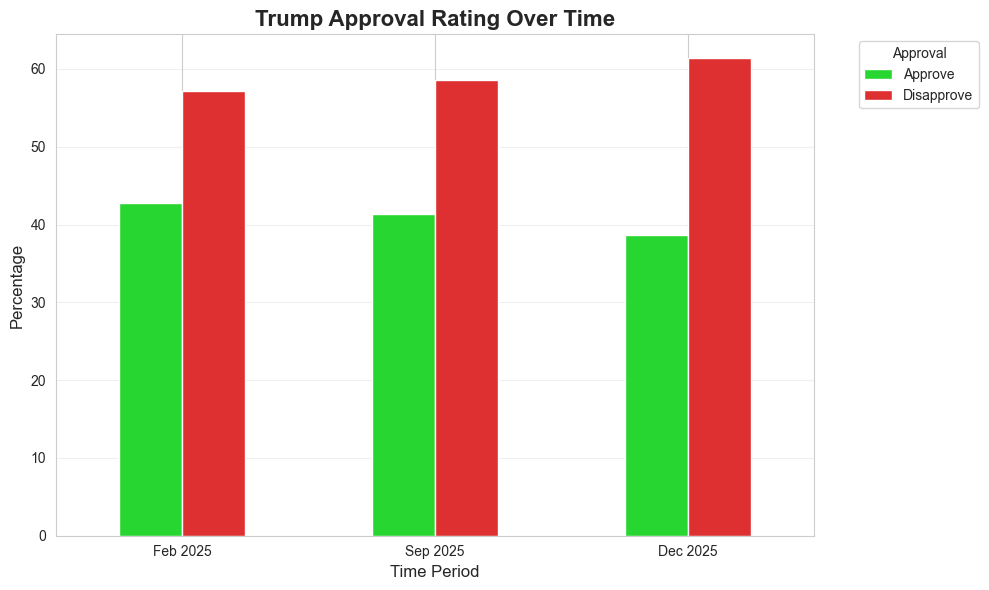


Approval percentages by time period:
TRUDPAPP      Approve  Disapprove
PROJECT_NAME                     
US20250224       42.8        57.2
US20250922       41.4        58.6
US20251208       38.6        61.4


In [74]:
# Calculate approval rates over time
approval_by_time = df_clean.groupby(['PROJECT_NAME', 'TRUDPAPP']).size().unstack(fill_value=0)
approval_pct = approval_by_time.div(approval_by_time.sum(axis=1), axis=0) * 100

# Reindex to ensure correct order
time_order = ['US20250224', 'US20250922', 'US20251208']
approval_pct = approval_pct.reindex(time_order)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
approval_pct.plot(kind='bar', ax=ax, color=["#27d630", "#de3030"])
ax.set_title('Trump Approval Rating Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Time Period', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_xticklabels(['Feb 2025', 'Sep 2025', 'Dec 2025'], rotation=0)
ax.legend(title='Approval', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nApproval percentages by time period:")
print(approval_pct.round(1))

### 3.2 Trump Supporters by Party Affiliation over Time

/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/2312742177.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['is_supporter'] = (s.astype(str).str.strip().str.lower() == 'approve').astype(int)
/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/2312742177.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  party_support = df_clean.groupby(['PROJECT_NAME', 'parrecres'])['is_supporter'].mean() * 100


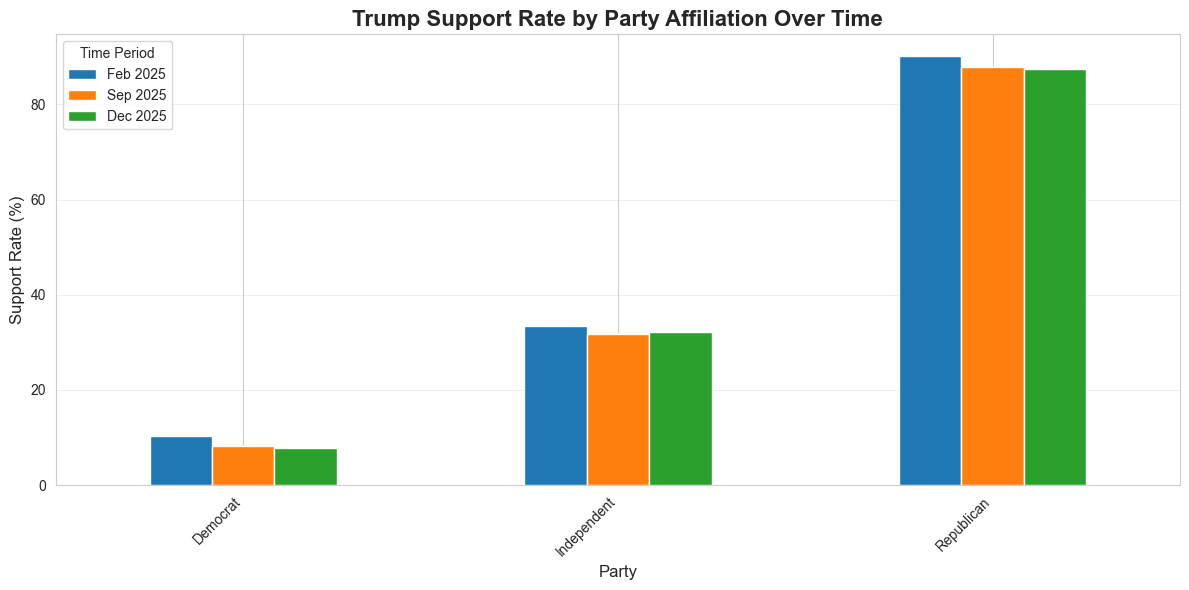


Support rates by party (%)
             Feb 2025  Sep 2025  Dec 2025
parrecres                                
Democrat         10.2       8.3       7.7
Independent      33.3      31.7      32.1
Republican       90.2      87.9      87.5


In [75]:
s = df_clean['TRUDPAPP']

if pd.api.types.is_numeric_dtype(s):
    df_clean['is_supporter'] = (s == 1).astype(int)  # approve=1
else:
    df_clean['is_supporter'] = (s.astype(str).str.strip().str.lower() == 'approve').astype(int)


# Support rate by party affiliation and time
party_support = df_clean.groupby(['PROJECT_NAME', 'parrecres'])['is_supporter'].mean() * 100
party_support_df = party_support.unstack(level=0)

# Ensure correct column order (and don't break if any wave is missing)
time_order = ['US20250224', 'US20250922', 'US20251208']
party_support_df = party_support_df.reindex(columns=time_order)
party_support_df.columns = ['Feb 2025', 'Sep 2025', 'Dec 2025']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
party_support_df.plot(kind='bar', ax=ax)
ax.set_title('Trump Support Rate by Party Affiliation Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Party', fontsize=12)
ax.set_ylabel('Support Rate (%)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Time Period')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSupport rates by party (%)")
print(party_support_df.round(1))

### 3.3 Support by Race, Gender, and whether is a College graduate or not

/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/3936814981.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demo_support = df_clean.groupby([demo, 'PROJECT_NAME'])['is_supporter'].mean() * 100
/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/3936814981.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demo_support = df_clean.groupby([demo, 'PROJECT_NAME'])['is_supporter'].mean() * 100
/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/3936814981.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pand

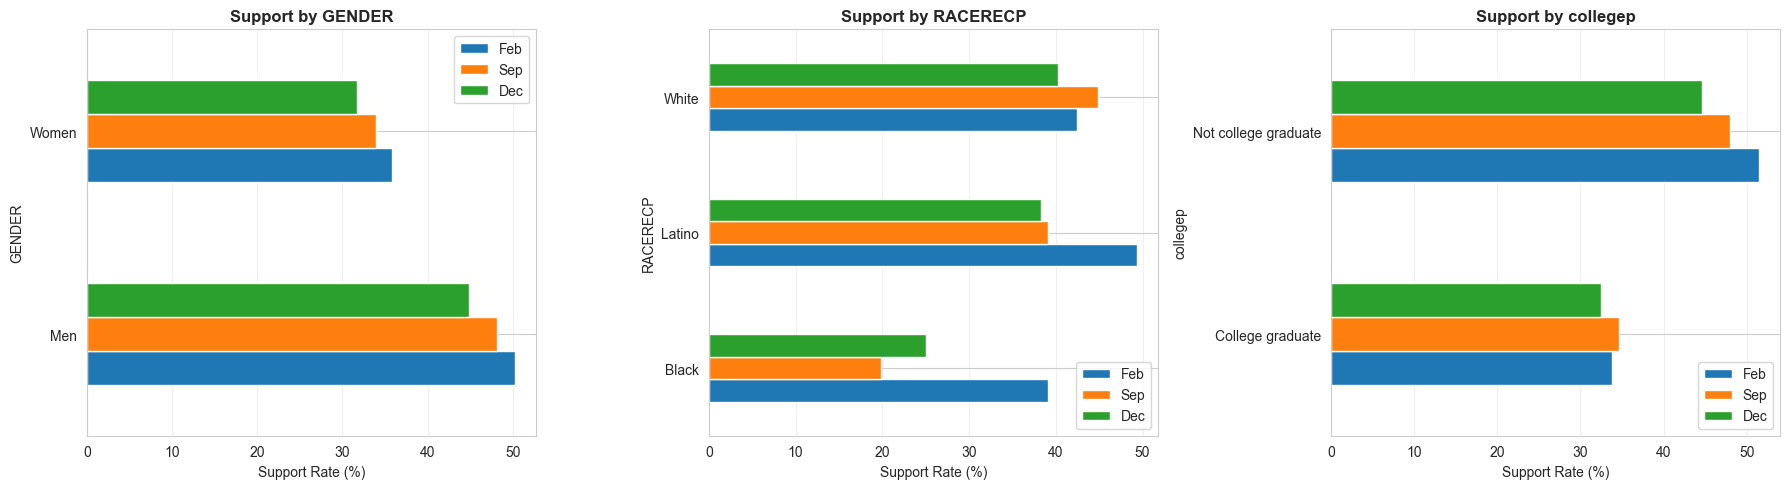

In [76]:
# Support by demographics
demographics = ['GENDER', 'RACERECP', 'collegep']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, demo in enumerate(demographics):
    demo_support = df_clean.groupby([demo, 'PROJECT_NAME'])['is_supporter'].mean() * 100
    demo_support_df = demo_support.unstack(level=1)
    
    # Ensure correct column order
    time_order = ['US20250224', 'US20250922', 'US20251208']
    demo_support_df = demo_support_df[time_order]
    demo_support_df.columns = ['Feb', 'Sep', 'Dec']
    
    demo_support_df.plot(kind='barh', ax=axes[idx])
    axes[idx].set_title(f'Support by {demo}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Support Rate (%)')
    axes[idx].grid(axis='x', alpha=0.3)
    
plt.tight_layout()
plt.show()

### 3.3 Support by Age (under/over 45)

/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/3903987141.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_support = df_age.groupby(['age45', 'PROJECT_NAME'])['is_supporter'].mean() * 100


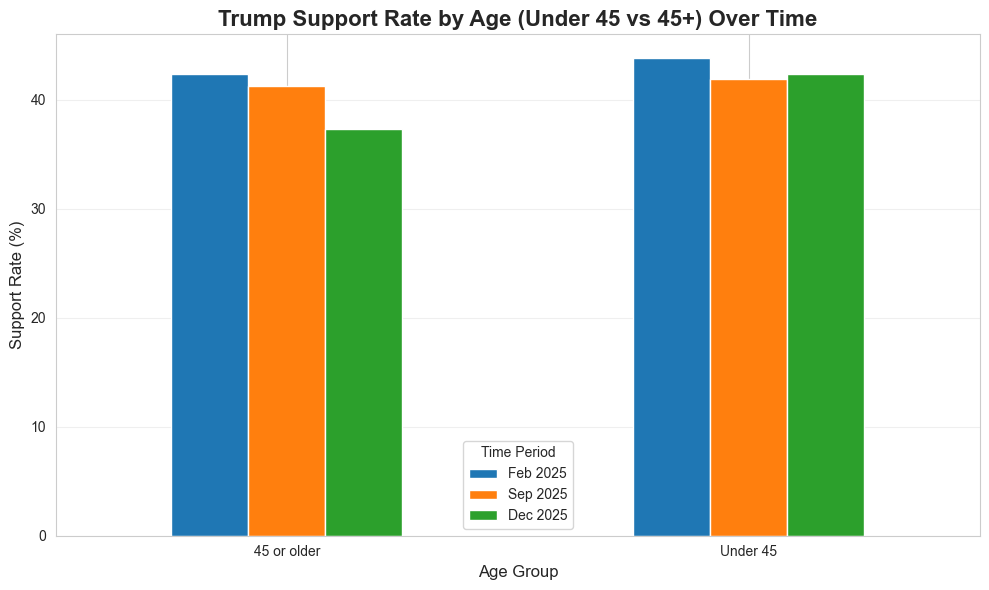


Support rates by age group (%)
             Feb 2025  Sep 2025  Dec 2025
age45                                    
45 or older      42.3      41.2      37.3
Under 45         43.8      41.9      42.4


In [77]:
# age45 codes: 1=Under 45, 2=45+, 0=NR

# Drop NR 
df_age = df_clean.dropna(subset=['age45']).copy()

# Support by age group over time
age_support = df_age.groupby(['age45', 'PROJECT_NAME'])['is_supporter'].mean() * 100
age_support_df = age_support.unstack(level=1)

# Ensure correct column order (safe)
time_order = ['US20250224', 'US20250922', 'US20251208']
age_support_df = age_support_df.reindex(columns=time_order)
age_support_df.columns = ['Feb 2025', 'Sep 2025', 'Dec 2025']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
age_support_df.plot(kind='bar', ax=ax)
ax.set_title('Trump Support Rate by Age (Under 45 vs 45+) Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Age Group', fontsize=12)
ax.set_ylabel('Support Rate (%)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Time Period')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSupport rates by age group (%)")
print(age_support_df.round(1))


## 4. Tracking Changes Over Time

### 4.1 Which demographic groups changed the most?

In [78]:
def calculate_change(df, demographic_var):
    """Calculate change in support from Feb to Dec for each demographic group"""
    support_by_demo = df.groupby([demographic_var, 'PROJECT_NAME'])['is_supporter'].mean() * 100
    support_pivot = support_by_demo.unstack(level=1)
    
    support_pivot['change_feb_dec'] = support_pivot['US20251208'] - support_pivot['US20250224']
    support_pivot['change_sep_dec'] = support_pivot['US20251208'] - support_pivot['US20250922']
    
    return support_pivot.sort_values('change_feb_dec', ascending=False)

# Calculate changes for each demographic
print("="*80)
print("CHANGES IN TRUMP SUPPORT: FEBRUARY TO DECEMBER 2025")
print("="*80)

for demo in ['parrecres', 'age45', 'GENDER', 'RACERECP', 'collegep']:
    print(f"\n{demo.upper()}:")
    print("-" * 80)
    change_df = calculate_change(df_clean, demo)
    print(change_df[['US20250224', 'US20251208', 'change_feb_dec']].round(1))
    print()

CHANGES IN TRUMP SUPPORT: FEBRUARY TO DECEMBER 2025

PARRECRES:
--------------------------------------------------------------------------------
PROJECT_NAME  US20250224  US20251208  change_feb_dec
parrecres                                           
Independent         33.3        32.1            -1.2
Democrat            10.2         7.7            -2.5
Republican          90.2        87.5            -2.7


AGE45:
--------------------------------------------------------------------------------
PROJECT_NAME  US20250224  US20251208  change_feb_dec
age45                                               
Under 45            43.8        42.4            -1.4
45 or older         42.3        37.3            -5.0


GENDER:
--------------------------------------------------------------------------------
PROJECT_NAME  US20250224  US20251208  change_feb_dec
GENDER                                              
Women               35.8        31.7            -4.1
Men                 50.2        44.8  

/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/3904140067.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support_by_demo = df.groupby([demographic_var, 'PROJECT_NAME'])['is_supporter'].mean() * 100
/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/3904140067.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support_by_demo = df.groupby([demographic_var, 'PROJECT_NAME'])['is_supporter'].mean() * 100
/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/3904140067.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future

/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/3904140067.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support_by_demo = df.groupby([demographic_var, 'PROJECT_NAME'])['is_supporter'].mean() * 100
/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/3904140067.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  support_by_demo = df.groupby([demographic_var, 'PROJECT_NAME'])['is_supporter'].mean() * 100
/var/folders/c7/6lsgyqjj5cg92kfy396d9rmc0000gn/T/ipykernel_744/3904140067.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future

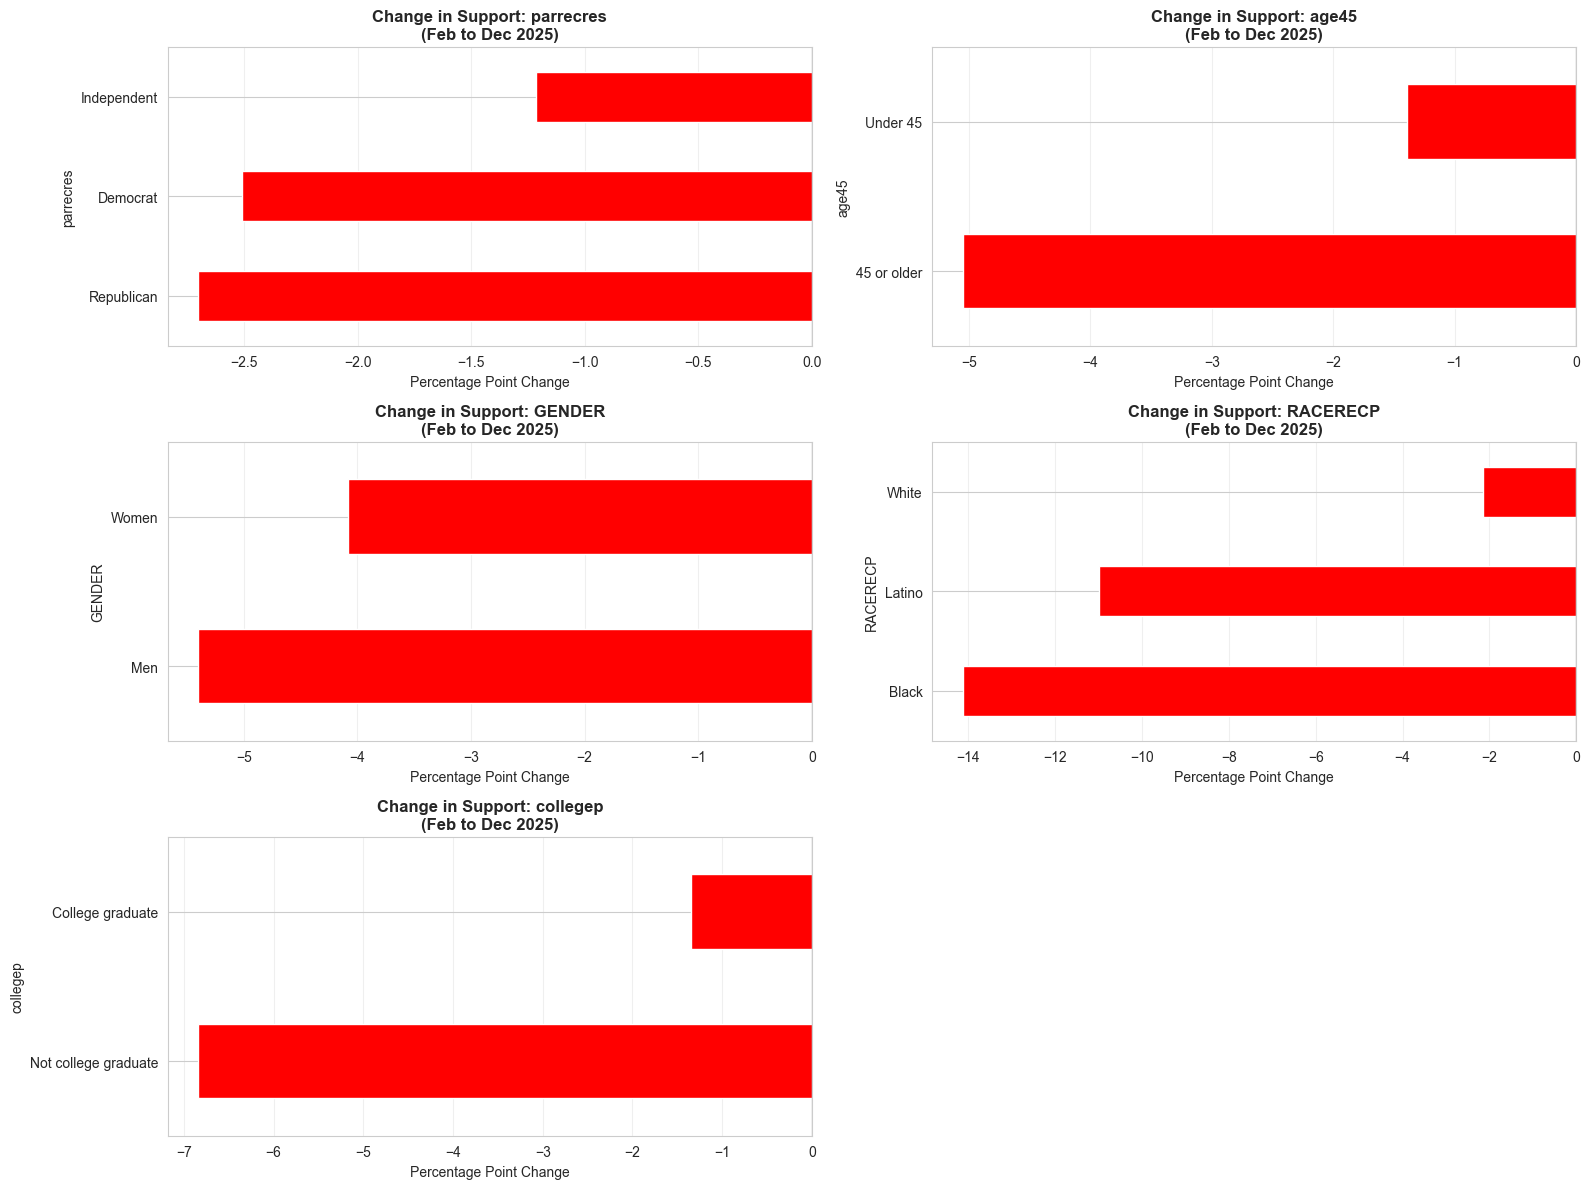

In [79]:
demo_vars = ['parrecres', 'age45', 'GENDER', 'RACERECP', 'collegep']

n = len(demo_vars)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4*nrows))
axes = np.array(axes).flatten()

for idx, demo in enumerate(demo_vars):
    change_df = calculate_change(df_clean, demo)

    s = change_df['change_feb_dec'].sort_values()
    colors = ['red' if x < 0 else 'green' for x in s.values]

    s.plot(kind='barh', ax=axes[idx], color=colors)
    axes[idx].set_title(f'Change in Support: {demo}\n(Feb to Dec 2025)', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Percentage Point Change', fontsize=10)
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].grid(axis='x', alpha=0.3)

# Remove unused subplots (if any)
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 5. Bayesian Network Analysis

Model how demographic factors and past approval influence current approval over time.

In [80]:
# -----------------------------
# Variables (ONLY these)
# -----------------------------
BN_VARS = ['TRUDPAPP','USA1000','parrecres','age45','GENDER','RACERECP','collegep','increc50']
WAVES = ['US20250224', 'US20250922', 'US20251208']
WAVE_LABELS = {'US20250224':'Feb 2025', 'US20250922':'Sep 2025', 'US20251208':'Dec 2025'}

# Keep PROJECT_NAME for splitting, encode the rest
bn_input = df_clean[['PROJECT_NAME'] + BN_VARS].copy()

# -----------------------------
# Encode discrete data safely
#   - If a column is numeric, keep numeric
#   - If labels (object/category), convert to category codes
#   - Special case TRUDPAPP if it is "Approve"/"Disapprove"
# -----------------------------
def encode_bn_data(df, cols):
    df = df.copy()
    codebooks = {}  # {col: {code: label}}

    for col in cols:
        s = df[col]

        # TRUDPAPP special handling if labels
        if col == 'TRUDPAPP' and not pd.api.types.is_numeric_dtype(s):
            s2 = s.astype(str).str.strip().str.lower()
            df[col] = s2.map({'approve': 1, 'disapprove': 2})
            codebooks[col] = {1:'Approve', 2:'Disapprove'}
            continue

        # If numeric-ish: coerce to numeric
        if pd.api.types.is_numeric_dtype(s):
            df[col] = pd.to_numeric(s, errors='coerce')
            continue

        # Otherwise: categorical labels -> integer codes
        cat = s.astype('category')
        labels = list(cat.cat.categories)
        codes = cat.cat.codes.replace(-1, np.nan)
        df[col] = codes
        codebooks[col] = {i: lab for i, lab in enumerate(labels)}

    # Drop missing in BN vars
    df = df.dropna(subset=cols).copy()

    # Cast BN vars to int
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(int)

    return df, codebooks

bn_df, codebooks = encode_bn_data(bn_input, BN_VARS)

print("BN data shape:", bn_df.shape)
print("TRUDPAPP values present:", sorted(bn_df['TRUDPAPP'].unique()))

#Label maps

LABEL_MAPS = {
    'parrecres': {
        1: 'Democrat',
        2: 'Republican',
        3: 'Independent'
    },
    'increc50': {
        1: 'Less than $50,000',
        2: '$50,000 or more'
    },
    'collegep': {
        1: 'Not college graduate',
        2: 'College graduate'
    },
    'RACERECP': {
        1: 'White',
        2: 'Black',
        3: 'Latino'
    },
    'age45': {
        1: 'Under 45',
        2: '45 or older'
    },
    'GENDER': {
        1: 'Men',
        2: 'Women'
    },
    'MKTCDC': {
        1: 'Northeast',
        2: 'Midwest',
        3: 'South',
        4: 'West'
    }
}

# Codes that should be treated as missing and removed from analysis
MISSING_CODES = {
    'parrecres': [7, 9],
    'increc50': [8, 9],
    'collegep': [7, 8, 9],
    'RACERECP': [7, 9],
    'age45': [0],
    'GENDER': [9]
}

# Build label maps that match bn_df's actual state coding
# (because bn_df may be 0/1/2 category codes instead of original codebook codes)

BN_LABEL_MAPS = {}

for var in ['parrecres','age45','GENDER','RACERECP','collegep','increc50','USA1000']:
    if var not in bn_df.columns:
        continue

    # Use your original LABEL_MAPS if possible (but remap to bn_df observed codes)
    observed = sorted(bn_df[var].dropna().unique())

    # If observed codes start at 0, assume category-coding happened.
    # We remap 0..k-1 to the ordered labels from your codebook (1..)
    if min(observed) == 0 and var in LABEL_MAPS:
        # labels from your codebook, in code order (1,2,3,...)
        ordered_labels = [LABEL_MAPS[var][k] for k in sorted(LABEL_MAPS[var].keys())]
        # match the number of observed states
        BN_LABEL_MAPS[var] = {int(c): ordered_labels[i] for i, c in enumerate(observed) if i < len(ordered_labels)}
    else:
        # otherwise, just use LABEL_MAPS directly
        BN_LABEL_MAPS[var] = {int(k): v for k, v in LABEL_MAPS.get(var, {}).items()}

def apply_missing_codes(df, missing_codes=MISSING_CODES):
    df = df.copy()
    for col, codes in missing_codes.items():
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df.loc[df[col].isin(codes), col] = np.nan
    return df
def label_value(var, code):
    try:
        code_int = int(code)
    except Exception:
        try:
            code_int = int(float(code))
        except Exception:
            return str(code)

    return BN_LABEL_MAPS.get(var, {}).get(code_int, str(code_int))





BN data shape: (3527, 9)
TRUDPAPP values present: [np.int64(1), np.int64(2)]


## 5.1 Define BN structure (interpretable) + fit per wave

In [81]:
bn_edges = [
    ('parrecres', 'USA1000'),  # party influences country direction perception

    ('parrecres', 'TRUDPAPP'),
    ('age45', 'TRUDPAPP'),
    ('GENDER', 'TRUDPAPP'),
    ('RACERECP', 'TRUDPAPP'),
    ('collegep', 'TRUDPAPP'),
    ('increc50', 'TRUDPAPP'),
    ('USA1000', 'TRUDPAPP'),
]

def fit_bn(df_wave):
    model = BayesianNetwork(bn_edges)
    model.fit(df_wave[BN_VARS], estimator=MaximumLikelihoodEstimator)
    infer = VariableElimination(model)
    return model, infer

bn_models = {}
bn_infer = {}

for w in WAVES:
    df_w = bn_df[bn_df['PROJECT_NAME'] == w].copy()
    bn_models[w], bn_infer[w] = fit_bn(df_w)
    print(f"Fitted BN for {WAVE_LABELS[w]} (n={len(df_w)})")


Fitted BN for Feb 2025 (n=1322)
Fitted BN for Sep 2025 (n=1123)
Fitted BN for Dec 2025 (n=1082)


## 5.2 Visualize the BN

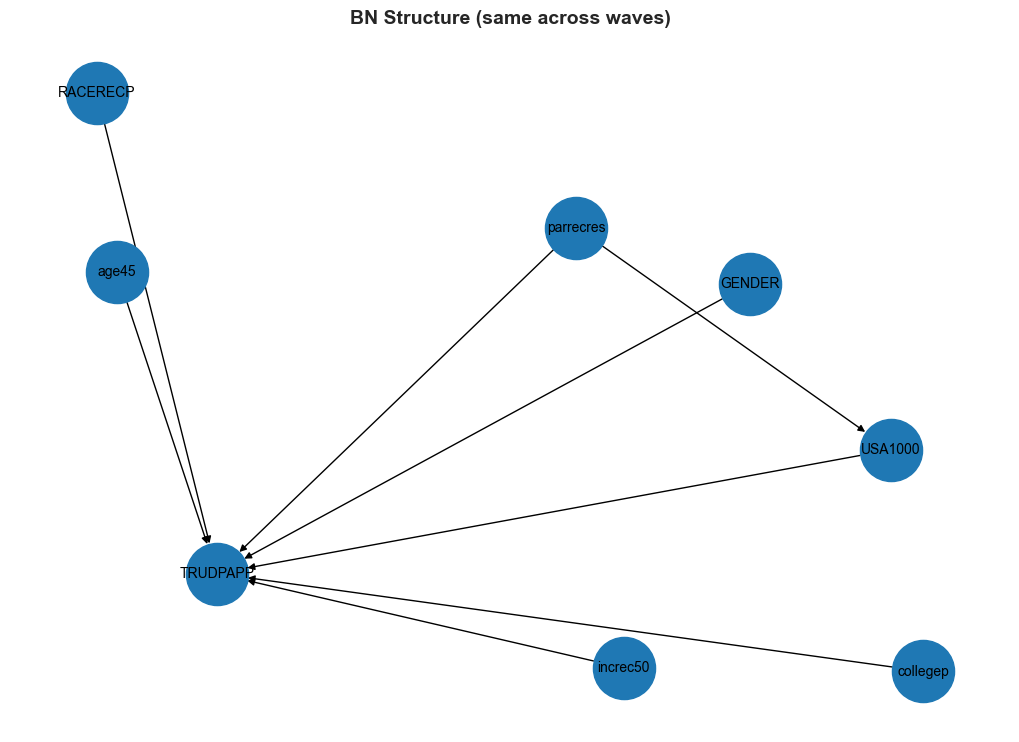

In [82]:
def plot_bn(model, title="Bayesian Network Structure"):
    G = nx.DiGraph()
    G.add_edges_from(model.edges())

    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42, k=0.7)
    nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, arrows=True)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

plot_bn(bn_models['US20250224'], "BN Structure (same across waves)")

## 5.3 Marginal approval by wave (BN-implied)

In [83]:
APPROVE_CODE = 1  # approve=1 if TRUDPAPP is 1/2; otherwise adjust based on your coding

def p_approve(wave, evidence=None):
    q = bn_infer[wave].query(variables=['TRUDPAPP'], evidence=evidence, show_progress=False)
    # q.values is aligned to sorted states; pgmpy uses the CPD state ordering.
    # Since we encoded TRUDPAPP as 1/2, we’ll map index by state name.
    states = q.state_names['TRUDPAPP']
    idx = states.index(APPROVE_CODE) if APPROVE_CODE in states else 0
    return float(q.values[idx])

approval_bn = pd.Series({WAVE_LABELS[w]: p_approve(w) * 100 for w in WAVES})
print("BN-implied Approval % by wave:")
print(approval_bn.round(1))


BN-implied Approval % by wave:
Feb 2025    41.0
Sep 2025    39.5
Dec 2025    36.5
dtype: float64


## 5.4 Conditional approval by each demographic (BN-implied)

In [84]:
def conditional_table(var):
    rows = []
    # possible states observed in data
    states = sorted(bn_df[var].unique())
    # label map if available
    lab = codebooks.get(var, {})
    for s in states:
        name = lab.get(s, str(s))
        row = {'Group': name, 'code': s}
        for w in WAVES:
            row[WAVE_LABELS[w]] = p_approve(w, evidence={var: int(s)}) * 100
        rows.append(row)
    out = pd.DataFrame(rows).drop(columns=['code'])
    return out.sort_values(by='Group')

for var in ['parrecres','age45','GENDER','RACERECP','collegep','increc50','USA1000']:
    print(f"\nBN-implied P(Approve) by {var} (%)")
    display(conditional_table(var).round(1))



BN-implied P(Approve) by parrecres (%)


,Group,Feb 2025,Sep 2025,Dec 2025
0,Democrat,8.6,8.1,6.9
1,Independent,32.5,31.5,31.2
2,Republican,87.3,82.5,82.5



BN-implied P(Approve) by age45 (%)


,Group,Feb 2025,Sep 2025,Dec 2025
0,45 or older,40.5,38.7,35.5
1,Under 45,42.1,42.0,39.3



BN-implied P(Approve) by GENDER (%)


,Group,Feb 2025,Sep 2025,Dec 2025
0,Men,41.7,39.4,38.1
1,Women,40.4,39.7,34.8



BN-implied P(Approve) by RACERECP (%)


,Group,Feb 2025,Sep 2025,Dec 2025
0,Black,39.4,35.4,32.1
1,Latino,41.6,38.9,34.7
2,White,41.2,40.2,37.3



BN-implied P(Approve) by collegep (%)


,Group,Feb 2025,Sep 2025,Dec 2025
0,College graduate,40.5,37.1,36.5
1,Not college graduate,41.5,41.8,36.6



BN-implied P(Approve) by increc50 (%)


,Group,Feb 2025,Sep 2025,Dec 2025
0,"$50,000 or more",41.6,39.2,35.6
1,"Less than $50,000",40.0,40.1,38.3



BN-implied P(Approve) by USA1000 (%)


,Group,Feb 2025,Sep 2025,Dec 2025
0,The right direction,90.3,87.4,89.0
1,The wrong direction,6.5,10.6,7.0
2,Vol: Unsure,54.4,50.8,45.8


## 6. Key Findings Summary

In [85]:
def key_findings_for_var(var):
    tab = conditional_table(var).copy()
    feb = 'Feb 2025'
    dec = 'Dec 2025'
    tab['Change (Feb→Dec)'] = tab[dec] - tab[feb]

    # Best group each wave
    top_feb = tab.loc[tab[feb].idxmax(), ['Group', feb]]
    top_dec = tab.loc[tab[dec].idxmax(), ['Group', dec]]

    # Biggest shifts
    up = tab.loc[tab['Change (Feb→Dec)'].idxmax(), ['Group', 'Change (Feb→Dec)']]
    down = tab.loc[tab['Change (Feb→Dec)'].idxmin(), ['Group', 'Change (Feb→Dec)']]

    return {
        "var": var,
        "top_feb": (top_feb['Group'], float(top_feb[feb])),
        "top_dec": (top_dec['Group'], float(top_dec[dec])),
        "up": (up['Group'], float(up['Change (Feb→Dec)'])),
        "down": (down['Group'], float(down['Change (Feb→Dec)']))
    }

print("\n================ KEY FINDINGS (BN) ================")
print(f"Overall BN-implied approval: {approval_bn['Feb 2025']:.1f}% → {approval_bn['Dec 2025']:.1f}% (Feb→Dec)")

for var in ['parrecres','age45','GENDER','RACERECP','collegep','increc50','USA1000']:
    k = key_findings_for_var(var)
    print(f"\n• {k['var']}:")
    print(f"  - Highest approval (Feb): {k['top_feb'][0]} ({k['top_feb'][1]:.1f}%)")
    print(f"  - Highest approval (Dec): {k['top_dec'][0]} ({k['top_dec'][1]:.1f}%)")
    print(f"  - Biggest increase Feb→Dec: {k['up'][0]} ({k['up'][1]:+.1f} pp)")
    print(f"  - Biggest decrease Feb→Dec: {k['down'][0]} ({k['down'][1]:+.1f} pp)")



================ KEY FINDINGS (BN) ================
Overall BN-implied approval: 41.0% → 36.5% (Feb→Dec)

• parrecres:
  - Highest approval (Feb): Republican (87.3%)
  - Highest approval (Dec): Republican (82.5%)
  - Biggest increase Feb→Dec: Independent (-1.3 pp)
  - Biggest decrease Feb→Dec: Republican (-4.8 pp)

• age45:
  - Highest approval (Feb): Under 45 (42.1%)
  - Highest approval (Dec): Under 45 (39.3%)
  - Biggest increase Feb→Dec: Under 45 (-2.7 pp)
  - Biggest decrease Feb→Dec: 45 or older (-5.0 pp)

• GENDER:
  - Highest approval (Feb): Men (41.7%)
  - Highest approval (Dec): Men (38.1%)
  - Biggest increase Feb→Dec: Men (-3.6 pp)
  - Biggest decrease Feb→Dec: Women (-5.6 pp)

• RACERECP:
  - Highest approval (Feb): Latino (41.6%)
  - Highest approval (Dec): White (37.3%)
  - Biggest increase Feb→Dec: White (-3.9 pp)
  - Biggest decrease Feb→Dec: Black (-7.3 pp)

• collegep:
  - Highest approval (Feb): Not college graduate (41.5%)
  - Highest approval (Dec): Not college g

In [86]:
from itertools import product

APPROVE_CODE = 1  # adjust if needed

DEMOS = ['parrecres','age45','GENDER','RACERECP','collegep','increc50','USA1000']

def best_profile_for_wave(wave):
    infer = bn_infer[wave]
    df_w = bn_df[bn_df['PROJECT_NAME'] == wave]

    # possible states for each demographic variable
    states = {var: sorted(df_w[var].unique()) for var in DEMOS}

    best_prob = 0
    best_profile = None

    for combo in product(*states.values()):
        evidence = dict(zip(DEMOS, combo))
        q = infer.query(['TRUDPAPP'], evidence=evidence, show_progress=False)

        states_tr = q.state_names['TRUDPAPP']
        idx = states_tr.index(APPROVE_CODE)
        prob = float(q.values[idx])

        if prob > best_prob:
            best_prob = prob
            best_profile = evidence

    return best_profile, best_prob

profiles = {}

for w in WAVES:
    profile, prob = best_profile_for_wave(w)
    profiles[w] = (profile, prob)
    print(f"\nBest profile for {WAVE_LABELS[w]}:")
    print(profile)
    print(f"Approval probability: {prob*100:.1f}%")


Best profile for Feb 2025:
{'parrecres': np.int64(0), 'age45': np.int64(0), 'GENDER': np.int64(0), 'RACERECP': np.int64(2), 'collegep': np.int64(0), 'increc50': np.int64(0), 'USA1000': np.int64(0)}
Approval probability: 100.0%

Best profile for Sep 2025:
{'parrecres': np.int64(0), 'age45': np.int64(0), 'GENDER': np.int64(0), 'RACERECP': np.int64(0), 'collegep': np.int64(0), 'increc50': np.int64(0), 'USA1000': np.int64(0)}
Approval probability: 100.0%

Best profile for Dec 2025:
{'parrecres': np.int64(0), 'age45': np.int64(0), 'GENDER': np.int64(0), 'RACERECP': np.int64(0), 'collegep': np.int64(0), 'increc50': np.int64(0), 'USA1000': np.int64(0)}
Approval probability: 100.0%


In [87]:
print("\n================= HUMAN READABLE PROFILE =================")

for w in WAVES:
    profile, prob = profiles[w]

    print(f"\n{WAVE_LABELS[w]} ({prob*100:.1f}%)")

    for var, code in profile.items():
        readable = label_value(var, code)
        print(f"  {var}: {readable}")



================= HUMAN READABLE PROFILE =================

Feb 2025 (100.0%)
  parrecres: Democrat
  age45: Under 45
  GENDER: Men
  RACERECP: Latino
  collegep: Not college graduate
  increc50: Less than $50,000
  USA1000: 0

Sep 2025 (100.0%)
  parrecres: Democrat
  age45: Under 45
  GENDER: Men
  RACERECP: White
  collegep: Not college graduate
  increc50: Less than $50,000
  USA1000: 0

Dec 2025 (100.0%)
  parrecres: Democrat
  age45: Under 45
  GENDER: Men
  RACERECP: White
  collegep: Not college graduate
  increc50: Less than $50,000
  USA1000: 0
